<a href="https://colab.research.google.com/github/aflah02/Easy-Data-Augmentation-Implementation/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
import numpy as np
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def eda_SR(originalSentence, n):
  """
  Paper Methodology -> Randomly choose n words from the sentence that are not stop words. 
                       Replace each of these words with one of its synonyms chosen at random.
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of words to be chosen for random synonym replacement
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy()
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    splitSentence[indexChosen] = random.choice(synonyms).replace('_', ' ')
  return " ".join(splitSentence)

In [3]:
print(eda_SR("I love to play football", 2))

I bed to run football


In [4]:
def eda_RI(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy() 
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  WordCount = len(splitSentence)
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    splitSentence.insert(random.randint(0,WordCount-1), random.choice(synonyms).replace('_', ' '))
  return " ".join(splitSentence)

In [5]:
print(eda_RI("I love to play football", 2))

I love to have it away playact play football


In [6]:
def eda_RS(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  splitSentence = list(originalSentence.split(" "))
  WordCount = len(splitSentence)
  if (WordCount == 1):
    raise Exception("No Swaps Possible in One Word Sentences")
  for i in range(n):
    firstIndex = random.randint(0,WordCount-1)
    secondIndex = random.randint(0,WordCount-1)
    while (secondIndex == firstIndex):
      secondIndex = random.randint(0,WordCount-1)
    splitSentence[firstIndex], splitSentence[secondIndex] = splitSentence[secondIndex], splitSentence[firstIndex]
  return " ".join(splitSentence)

In [7]:
print(eda_RS("I love to play football", 2))

to love I football play


In [8]:
def eda_RD(originalSentence, p):
  """
  Paper Methodology -> Randomly remove each word in the sentence with probability p.
  originalSentence -> The sentence on which EDA is to be applied
  p -> Probability of a Word Being Removed
  """
  if (p == 1):
      raise Exception("Always an Empty String Will Be Returned") 
  if (p > 1 or p < 0):
    raise Exception("Improper Probability Value")
  splitSentence = list(originalSentence.split(" "))
  lsIndexesRemoved = []
  WordCount = len(splitSentence)
  if (WordCount == 1):
    raise Exception("No Swaps Possible in One Word Sentences")
  for i in range(WordCount):
    randomDraw = random.random()
    if randomDraw <= p:
      lsIndexesRemoved.append(i)
  lsRetainingWords = []
  for i in range(len(splitSentence)):
    if i not in lsIndexesRemoved:
      lsRetainingWords.append(splitSentence[i])
  return " ".join(lsRetainingWords)

In [9]:
print(eda_RD("I love to play football", 0.3))

I to football


### Building Dataset

In [10]:
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/dev.tsv

In [11]:
!mkdir train

In [12]:
import pandas as pd
df_train = pd.read_csv('train.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
# df_train['Split'] = 'Train'
df_dev = pd.read_csv('dev.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
# df_dev['Split'] = 'Train' # Since The Original Dataset Does Not Use an Explicit Dev Set It's Considered To Be A Part of Test Set
df_test = pd.read_csv('test.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
# df_test['Split'] = 'Test'
df_train = pd.concat([df_train, df_dev])
df_train = df_train.reset_index(drop=True)
df_train = df_train.loc[:, ["Label", "Sentence"]]
df_train.to_csv('datasettrain.csv', index=False)
df_test = df_test.loc[:, ["Label", "Sentence"]]
df_test.to_csv('datasettest.csv', index=False)

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pickle

In [14]:
column_names = ['Label','Sentence']
batchsize = 1
label = column_names[0]
train_dataset = tf.data.experimental.make_csv_dataset(
    'datasettrain.csv',
    batchsize,
    column_names = column_names,
    label_name = label,
    num_epochs=1
)

In [15]:
column_names = ['Label','Sentence']
batchsize = 32
label = column_names[0]
test_dataset = tf.data.experimental.make_csv_dataset(
    'datasettest.csv',
    batchsize,
    column_names = column_names,
    label_name = label,
    num_epochs=1
)

In [16]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [81]:
ls_train = []
for example, label in train_dataset:
  ls_train.append([example['Sentence'][0],label[0]])

nparrtrainsentences = np.array([])
nparrtrainlabels = np.array([])
for i in range(len(ls_train)):
  nparrtrainsentences = np.append(nparrtrainsentences, [ls_train[i][0].numpy()])
  nparrtrainlabels = np.append(nparrtrainlabels, [ls_train[i][1].numpy()])

train_sentences = tf.convert_to_tensor(nparrtrainsentences)
train_labels = tf.convert_to_tensor(nparrtrainlabels)

train_dataset = tf.data.Dataset.from_tensors((train_sentences,train_labels))

In [82]:
ls_test = []
for example, label in test_dataset:
  ls_test.append([example['Sentence'][0],label[0]])

nparrtestsentences = np.array([])
nparrtestlabels = np.array([])
for i in range(len(ls_test)):
  nparrtestsentences = np.append(nparrtestsentences, [ls_test[i][0].numpy()])
  nparrtestlabels = np.append(nparrtestlabels, [ls_test[i][1].numpy()])

test_sentences = tf.convert_to_tensor(nparrtestsentences)
test_labels = tf.convert_to_tensor(nparrtestlabels)

test_dataset = tf.data.Dataset.from_tensors((test_sentences,test_labels))

In [83]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'the script manages the rare trick of seeming at once both refreshingly different and reassuringly familiar'
 b'in questioning the election process , payami graphically illustrates the problems of fledgling democracies , but also the strength and sense of freedom the iranian people already possess , with or without access to the ballot box'
 b'very amusing , not the usual route in a thriller , and the performances are odd and pixilated and sometimes both']

labels:  [1. 1. 1.]


In [87]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]

# encoded_example = encoder(example)[:3].numpy()
# encoded_example

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'the script manages the rare trick of seeming at once both refreshingly different and reassuringly familiar'
Round-trip:  the script manages the rare trick of seeming at once both refreshingly different and [UNK] familiar                                

Original:  b'in questioning the election process , payami graphically illustrates the problems of fledgling democracies , but also the strength and sense of freedom the iranian people already possess , with or without access to the ballot box'
Round-trip:  in [UNK] the [UNK] process payami [UNK] illustrates the problems of [UNK] [UNK] but also the strength and sense of freedom the iranian people already possess with or without [UNK] to the ballot box              

Original:  b'very amusing , not the usual route in a thriller , and the performances are odd and pixilated and sometimes both'
Round-trip:  very amusing not the usual [UNK] in a thriller and the performances are odd and [UNK] and sometimes both                   

## RNN Model

Paper Uses - 
The architecture used in this paper is as follows: input layer, bi-directional hidden layer with 64 LSTM cells, dropout layer with p=0.5, bi-directional layer of 32 LSTM cells, dropout layer with p=0.5, dense layer of 20 hidden units with ReLU activation, softmax output layer. We initialize this network with random normal weights and train against the categorical crossentropy loss function with the adam optimizer. We use early stopping with a patience of 3 epochs.

Reference for Encoder and some Helper Functions: [Tensorflow Text Classification by RNN Tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn)



In [112]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

model.fit(	
      dataset,
      epochs=3, 
      callbacks=callbacks,
)

Epoch 1/3
1/1 [==============================] - 19s 19s/step - loss: 0.0000e+00 - accuracy: 0.5203
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.5203
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.5203


In [114]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - accuracy: 0.4561
Test Loss: 0.0
Test Accuracy: 0.45614033937454224


(0.0, 0.6936489075422287)

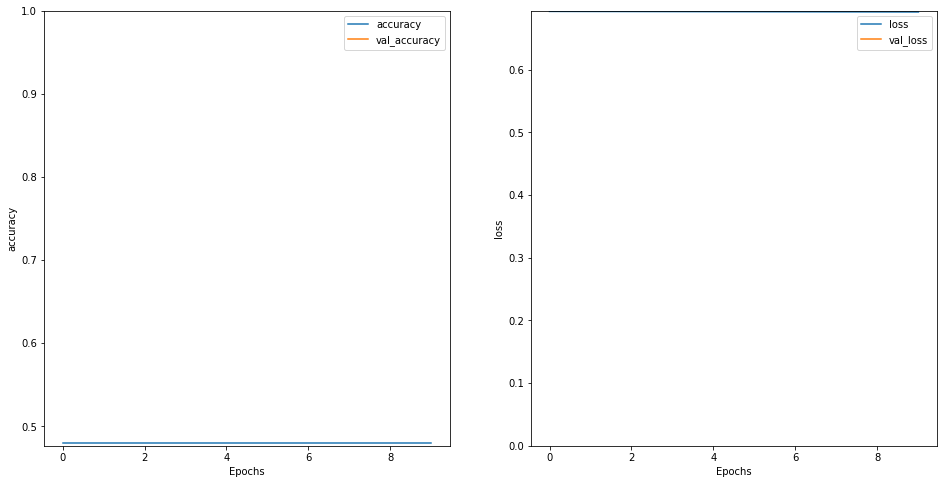

In [115]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)